In [112]:
import locale

import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from main import prognose
from scipy import stats
import seaborn as sns
import matplotlib as mpl
from cycler import cycler

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
#pd.set_option('display.float_format', lambda x: '%0.3e' % x)
pd.set_option('display.float_format', lambda x: '%0.9f' % x)

# Präsentation
## Mirko Matošin und Alexander Wünstel
Lese ein, erstelle statistische Größen

In [ ]:
from main import prognose, getsecs
sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
sieb_energien.head()
tmpdf = sieb_energien.join(getsecs(sieb_energien))

Zusammengefasst:

In [ ]:
tmpdf.head()
# erstelle Plot-Vektoren

In [129]:
tmpdf['GesamtEnergie'].describe()
tmpdf.describe([.01, .5, .99])

,GesamtEnergie
count,18231.000000000
mean,1.411104347
std,7.264719321
min,0.064902961
1%,0.067131209
50%,0.980336726
99%,4.771029615
max,842.714538574


In [ ]:
from datetime import datetime

stundenweise = np.arange(0,len(sieb_energien)*2,60)
halbstundenweise = np.arange(0,len(sieb_energien)*2,30)

Plotte die Grundgesamtheit als Scatter um Ausreisser zu erkennen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


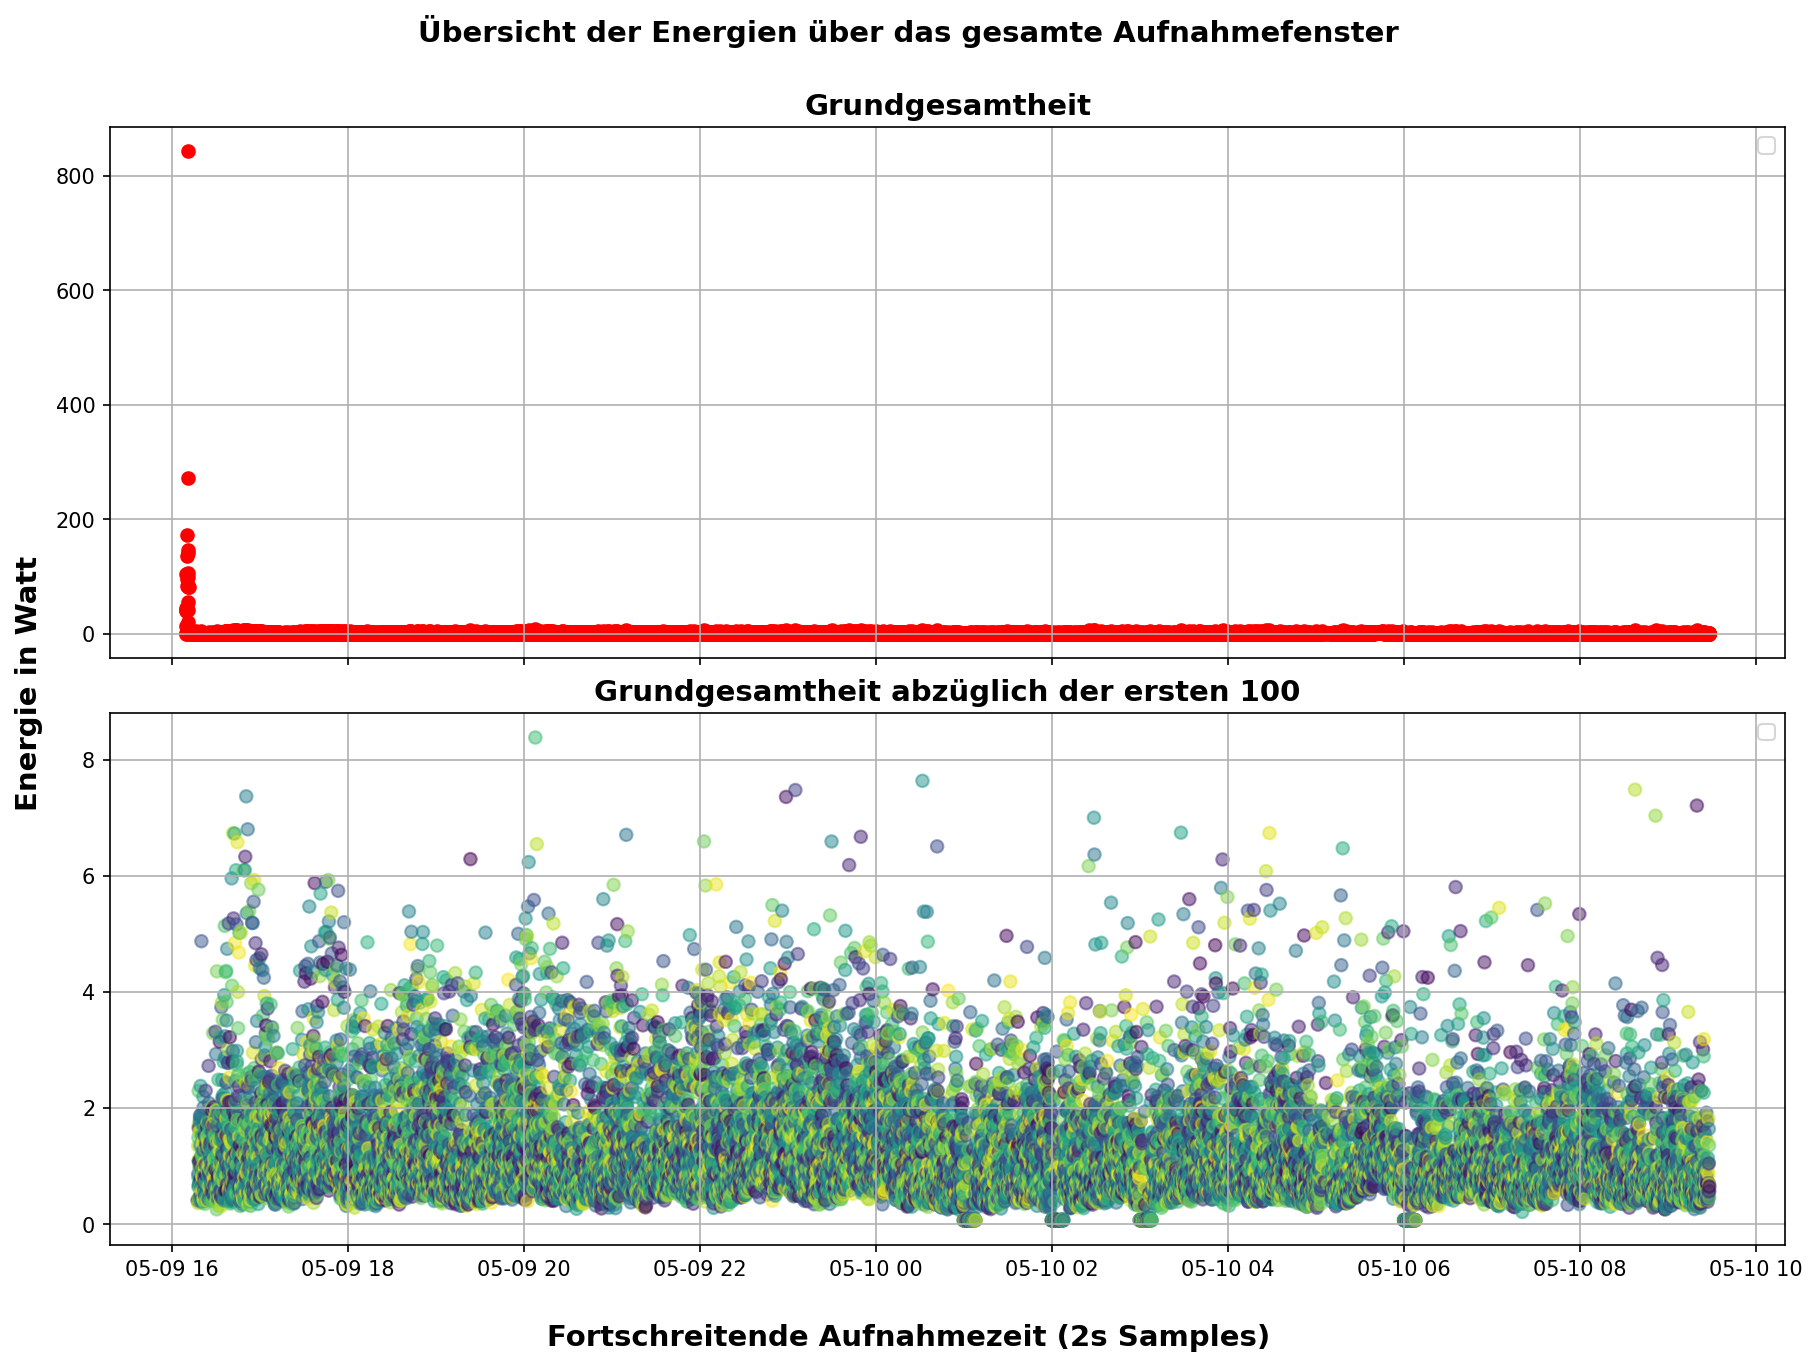

In [128]:
x = pd.to_datetime(tmpdf['rectime'], format = '%Y%m%d_%H_%M_%S')
fig, ax = plt.subplots(2,1,constrained_layout=True, sharex='all')  # , sharey='all')

for i in ax:
    i.grid('True')
    i.legend()



N = 18131
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2
alpha = np.random.rand(N)


ax[0].scatter(x=x, y=tmpdf['GesamtEnergie'])
ax[1].scatter(x=x[100:], y=tmpdf['GesamtEnergie'][100:],c=colors,alpha=.5)


fig.suptitle('Übersicht der Energien über das gesamte Aufnahmefenster\n',fontsize=14, fontweight='bold')
xlab = '\nFortschreitende Aufnahmezeit (2s Samples)'.format()
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Energie in Watt'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
#ax[0].text(60, .025, r'$\mu=100,\ \sigma=15$')

ax[0].set_title('Grundgesamtheit',fontsize=14, fontweight='bold')
ax[1].set_title('Grundgesamtheit abzüglich der ersten 100',fontsize=14, fontweight='bold')

plt.show()

Man kann eindeutige Ausreisser im oberen Plot sehen. Diese wurden im unteren Plot nicht dargestellt.

## Automatisierte Ausreisser-Erkennung
Im Folgenden soll unsere Herangehensweise erklärt werden. Für die Ausreisser-Erkennung haben wir uns einen einseitigen
Prognosebereich geeinigt. Ziel ist eine Grundgesamtheit minus Ausreisser.

In [ ]:
fig, ax = plt.subplots(3,1,constrained_layout=True)#, sharex='all')  # , sharey='all')
pwr = sieb_energien['GesamtEnergie'].copy() / 2 ** 15
mult = 2
n_bins = 1200
for i in ax:
    bins = np.linspace(pwr.min(), pwr.max(), n_bins)  # Create bins of equal size between min_value and max_value

    #pwr[:].hist(bins=bins, grid=True, log=True, ax=ax[0],alpha=0.33*mult)#, density=True, cumulative=True)
    pwr[:].hist(bins=bins, grid=True, log=True, ax=i)#, density=True, cumulative=True)
    progmax = prognose(pwr.to_numpy(), gamma=0.95, bereich='rechts')
    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr.index:
        if pwr.loc[x] > progmax:# or pwr.loc[x] < progmin:
            pwr = pwr.drop(x).copy()
    i.grid('True')


fig.suptitle('Prognose und Siebung ohne Transformation in Normalverteilung\n',fontsize=14, fontweight='bold')
xlab = 'Einteilung der Energie in {} Klassen (Bins)'.format(n_bins)
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Häufigkeiten der einzelnen Klassen'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
#ax[0].text(60, .025, r'$\mu=100,\ \sigma=15$')
ax[0].set_title('Grundgesamtheit')
ax[1].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 1')
ax[2].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 2')
#ax[0].set_ylabel('')
#ax[1].set_ylabel('')
#ax[2].set_ylabel('')
#fig.tight_layout()
plt.show()

Nun mit boxcox und stats.probplot

In [ ]:
from main import prognose
from scipy import stats
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)

fig, ax = plt.subplots(3,1,constrained_layout=True)#, sharex='all')  # , sharey='all')
#ax=ax.ravel()
mult = 2
n_bins = 1200
sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
pwr = sieb_energien['GesamtEnergie'].copy() / 2 ** 15
probpwr = stats.probplot(pwr, dist=stats.norm, plot=ax[0])


for i in ax[1:2]:
    #bins = np.linspace(pwr.min(), pwr.max(), n_bins)  # Create bins of equal size between min_value and max_value
    probpwr = stats.probplot(pwr, dist=stats.norm, plot=i)
    fitted_data, fitted_lambda = stats.boxcox(pwr)
    probfit = stats.probplot(fitted_data, dist=stats.norm, plot=i)
    progmax = prognose(pwr.to_numpy(), gamma=0.95, bereich='rechts')

    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr.index:
        if pwr.loc[x] > progmax:# or pwr.loc[x] < progmin:
            pwr = pwr.drop(x).copy()

for i in ax:
    i.grid('True')
    i.legend()

fig.suptitle('Prognose und Siebung mit Transformation in Normalverteilung\n',fontsize=14, fontweight='bold')
#xlab = 'Einteilung der Energie in {} Klassen (Bins)'.format(n_bins)
#fig.supxlabel(xlab, fontsize=14, fontweight='bold')
#ylab = 'Häufigkeiten der einzelnen'.format(n_bins)
#fig.supylabel(ylab, fontsize=14, fontweight='bold')
plt.show()

Nun mit boxcox und hist

In [ ]:
from main import prognose
from scipy import stats
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)

fig, ax = plt.subplots(3,1,constrained_layout=True)#, sharex='all')  # , sharey='all')
#ax=ax.ravel()
mult = 2
n_bins = 1200

sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
pwr = sieb_energien['GesamtEnergie'].copy() / 2 ** 15
bins = np.linspace(pwr.min(), pwr.max(), n_bins)
pwr[:].hist(bins=bins, grid=True, log=False, ax=ax[1], label='Original')


# Create bins of equal size between min_value and max_value
#for
fitted_data, fitted_lambda = stats.boxcox(pwr)
fitpwr = pandas.Series(fitted_data,index=pwr.index)
bins = np.linspace(fitpwr.min(), fitpwr.max(), n_bins)
i = ax[0]
fitpwr[:].hist(bins=bins, grid=True, log=False, ax=i, label='Original gefittet',alpha=0.6)#, density=True, cumulative=True
# Berechne 1. Schwellenwert
progmax = prognose(fitpwr.to_numpy(), gamma=0.95, bereich='rechts')

for x in fitpwr.index:
    if fitpwr.loc[x] > progmax:# or pwr.loc[x] < progmin:
        fitpwr = fitpwr.drop(x).copy()

bins = np.linspace(fitpwr.min(), fitpwr.max(), n_bins)
i = ax[0]
fitpwr[:].hist(bins=bins, grid=True, log=False, ax=i, label='Original gefittet')


print(pwr.shape)
fitlist = fitpwr.index.tolist()
for x in pwr.index:
    if x in fitlist:# or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)
print(pwr.shape)

bins = np.linspace(pwr.min(), pwr.max(), n_bins)
pwr[:].hist(bins=bins,color='g' ,grid=True, log=False, ax=ax[2], label='Original - Gesiebt anhand Boxcox')
axs = ax[2]
axs.set_title('Histogramm der gesiebten Daten')

for i in ax:
    i.grid('True')
    i.legend()

fig.suptitle('Prognose und Siebung mit Transformation in Normalverteilung\n',fontsize=14, fontweight='bold')
xlab = 'Einteilung der Energie in {} Klassen (Bins)'.format(n_bins)
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Häufigkeiten der einzelnen Klassen'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
plt.show()

In [ ]:
print(pwr.shape)
fitlist = fitpwr.index.tolist()
for x in pwr.index:
    if x in fitlist:# or pwr.loc[x] < progmin:
        pass
    else:
        pwr = pwr.drop(x).copy()
print(pwr.shape)

In [ ]:
x = ' 20220509_16_09_32.wav'
if x in fitlist:
    print("OK")

In [ ]:
print(os.getcwd())

In [ ]:
#os.chdir("bilder_doku")
#fig.savefig('boxcox.png')
os.chdir(r'C:\Users\mirko\PycharmProjects\ss22_dfss_clock')

In [ ]:
a = pwr.nsmallest(10)
print(a)

In [ ]:
pd.set_option('display.float_format', lambda x: '%0.3e' % x)


qu = sieb_energien['GesamtEnergie'].quantile(0.01)
qun = qu /2**15
txt = ('Erfahrungsgemäß ist der Untere Schwellenwert: \t{} Watt\n' +\
'oder Standardisiert: \t\t\t\t{}').format(qu,qun)
print(txt)
anzahl = 0
for x in sieb_energien.index:
    if sieb_energien['GesamtEnergie'].loc[x] > qu:# or pwr.loc[x] < progmin:
        pass
    else:
        anzahl +=1

txt = ('Es gibt insgesamt \t{} Werte die kleiner sind als {}').format(anzahl, qu)
print(txt)

txt = ('Daher werden diese Werte vor dem gelöscht').format(anzahl, qu)
print(txt)

qo = sieb_energien['GesamtEnergie'].quantile(0.999)
qon = qo /2**15
txt = ('Erfahrungsgemäß ist der obere Schwellenwert: \t{} Watt\n' +\
'oder Standardisiert: \t\t\t\t{}').format(qo,qon)
print(txt)
anzahl = 0
for x in sieb_energien.index:
    if sieb_energien['GesamtEnergie'].loc[x] < qo:# or pwr.loc[x] < progmin:
        pass
    else:
        anzahl +=1

txt = ('Es gibt insgesamt \t{} Werte die größer sind als {}').format(anzahl, qo)
print(txt)

txt = ('Eine Untersuchung ob diese Daten gelöscht werden, steht noch aus').format(anzahl, qu)
print(txt)



In [ ]:
minimalschwellle =pwr.quantile(0.01) # eigentlich lieber mit der fft für frequenzen kleiner 300 Hz

for x in pwr.index:
    if pwr.loc[x] > minimalschwellle:# or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)



In [ ]:
pwr.shape


